In [3]:
# import torch
# import torch.autograd as autograd
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.utils.data as data
# import torch.nn.functional as F
# import argparse
# torch.backends.cudnn.enabled = False
# torch.manual_seed(1)

import json
import time
import codecs
import pandas as pd
import numpy as np
import os
import re
import csv
import random
from tqdm import tqdm
from progressbar import ProgressBar
from pyltp import SentenceSplitter
from pyltp import Postagger
from pyltp import Segmentor

from pyltp import NamedEntityRecognizer
import jieba
import logging
import copy
from collections import Counter

# process_data

In [4]:
# 读取原始数据training.txt，保存为DataFrame格式
def read_data(file):
    start_time = time.time()
    with open(file, 'r', encoding='utf-8') as f:
        print('Reading...')
        lines = f.readlines()
        
        ids = []
        labels = []
        contents = []

        for line in lines:
#             text = line.encode('utf-8').decode('unicode_escape')
            text = json.loads(line)
            ids.append(text['id'])
            labels.append(text['标签'])
            contents.append(text['内容'])

    data = pd.DataFrame({
        'id': ids,
        'label': labels,
        'content': contents,
    })
    end_time = time.time()
    print('Time: %.2fs' % (end_time - start_time))
    return data



# 读取验证集或者测试集数据(无标签)
def read_train_data(file):
    start_time = time.time()
    with open(file, 'r', encoding='utf-8') as f:
        print('Reading...')
        lines = f.readlines()

        ids = []
        contents = []
        for line in lines:
            text = json.loads(line)
            ids.append(text['id'])
            contents.append(text['内容'])
    data = pd.DataFrame({'id': ids, 'content': contents})
    end_time = time.time()
    print('Time: %.2fs' % (end_time - start_time))
    return data

In [5]:
# 打标签 eng, num, date, time, 特殊字符special, 分段符sssss
def pad_alltags(content):
    content = re.sub(r'<|>', '', content)  # clean
    content = re.sub(r'[a-zA-Z]+', '<eng>', content)
    content = re.sub(r'\d+[年月日号]|(周|星期|礼拜)[一二三四五六七日天]', '<date>', content)
    content = re.sub(
        r'[\d零一二三四五六七八九十百千万亿]+天|\d+[时分秒|点半?钟?]|[1-2]\d{3}\D|\d{2}:\d{2}(:\d{2})?',
        '<time>', content)
    content = re.sub(r'[\d\.]+%?％?[十百千万亿]*|[零一二三四五六七八九十几]+[十百千万亿]+', '<num>',
                     content)
    content = re.sub(
        r'[^\u4e00-\u9fa5a-zA-Z ,\.?!%\*\(\)-_\+=`~#\|\{\}:;\"\'<>\^/\\\[\]，。、？！…·（）￥【】：；“”‘’《》—]',
        '<special>', content)
    content = '<sssss>'.join(SentenceSplitter.split(content))
    return content
    
# 统计tag信息
def count_tag(contents, tag):
    return [len(re.findall(tag, content)) for content in contents]


# 处理分词后的标签
def process_tags(words):
    pos_words = []
    tags = ['num', 'eng', 'date', 'time', 'special', 'sssss']
    for word in words:
        word = re.sub(r'<|>', '', word)
        if word == '':
            continue
        if word in tags:
            word = '<' + word + '>'
        if word.endswith('。') and len(word) > 1:
            pos_words.extend([word[:-1], '。'])
            continue
        pos_words.append(word)
    return pos_words


In [6]:
# 统计顿号
def count_comma(contents):
    div_re = re.compile(r'[、]+')
    return [len(re.findall(div_re, content)) for content in contents]


# 统计段落数
def count_para(contents):
    return [max(1, len(re.findall(r'<sssss>', content))) for content in contents]


# 统计句数
def count_sent(contents):
    div_re = re.compile(r"[,:;?!。；，：？！]+")  #unicode标点符号，。
    return [max(1, len(re.findall(div_re, content))) for content in contents]


# 统计文本长度(字符)
def get_text_len(contents):
    return [len(content) for content in contents]


# 统计文本长度(词)
def get_text_word_len(contents):
    return [len(re.sub(r'<sssss>', '', content).split(' ')) for content in contents]


# 第一段的长度(字符级别)
def first_para_length(contents):
    return [len(content.split('<sssss>')[0]) for content in contents]


# 第一段的长度(词级别)
def first_para_word_len(contents):
    return [len(content.split('<sssss>')[0].split(' ')) for content in contents]


# 最大段落长度(字符级别)
def max_para_length(contents):
    return [max([len(sent) for sent in content.split('<sssss>')]) for content in contents]


# 最小段落长度(字符级别)
def min_para_length(contents):
    return [min([len(sent) for sent in content.split('<sssss>') if sent.strip(' ') != '']) for content in contents]


# 最大段落长度(词级别)
def max_para_word_len(contents):
    return [max([len(sent.split(' ')) for sent in content.split('<sssss>')]) for content in contents]


# 最小段落长度(词级别)
def min_para_word_len(contents):
    return [min([len(sent.split(' ')) for sent in content.split('<sssss>')]) for content in contents]


# 第一句长度(字符级别)
def first_sent_length(contents):
    punc = r"[,\.:;?!。；，：？！…]+"  #unicode标点符号，。
    text = [re.sub(punc, '<sent>', content) for content in contents]
    return [len(t.split('<sent>')[0]) for t in text]


# 最大句长度(字符级别)
def max_sent_length(contents):
    punc = r"[,\.:;?!。；，：？！…]+"  #unicode标点符号，。
    text = [re.sub(punc, '<sent>', content) for content in contents]
    return [max([len(s) for s in t.split('<sent>')]) for t in text]


# 最大句长度(词级别)
def max_sent_word_len(contents):
    punc = r"[,\.:;?!。；，：？！…]+"  #unicode标点符号，。
    text = [re.sub(punc, '<sent>', content) for content in contents]
    return [max([len(s.split(' ')) for s in t.split('<sent>')]) for t in text]


# 最小句长度(字符级别)
def min_sent_length(contents):
    punc = r"[,\.:;?!。；，：？！…]+"  #unicode标点符号，。
    text = [re.sub(punc, '<sent>', content) for content in contents]
    return [min([len(s) for s in t.split('<sent>') if s.strip(' ') != '']) for t in text]


# 最小句长度(词级别)
def min_sent_word_len(contents):
    punc = r"[,\.:;?!。；，：？！…]+"  #unicode标点符号，。
    text = [re.sub(punc, '<sent>', content) for content in contents]
    return [min([len(s.split(' ')) for s in t.split('<sent>') if s.strip(' ') != '']) for t in text]


# 最后一个字符
def get_last_char(contents):
    vocab = get_vocabulary([content[-1] for content in contents], initial_vocab={}, vocabsize=18)
    last_chars = []
    for content in contents:
        last_char = content[-1]
        if vocab.get(last_char) is not None:
            last_chars.append(vocab[last_char])
        else:
            if re.match(r'[^\u3400-\u9fff]', content[-1]):
                last_chars.append(18)
            else:
                last_chars.append(19)
    return last_chars


# 第一个字符
def get_first_char(contents):
    vocab = get_vocabulary([content[0] for content in contents], initial_vocab={}, vocabsize=10)
    first_chars = []
    for content in contents:
        first_char = content[0]
        if vocab.get(first_char) is not None:
            first_chars.append(vocab[first_char])
        else:
            if re.match(r'[^\u3400-\u9fff]', content[-1]):
                first_chars.append(8)
            else:
                first_chars.append(9)
    return first_chars


# 最后一个词(用tfidf)
def get_last_word(words, vocab, tfidf):
    last_words = []
    for word in words:
        last_word = word[-1]
        if vocab.get(last_word) is not None:
            last_words.append(vocab[last_word])
        else:
            last_words.append(vocab['<unk>'])
    return last_words


# 第一个词(用tfidf)
def get_first_word(words, vocab, tfidf):
    first_words = []
    for word in words:
        first_word = word[0]
        if vocab.get(first_word) is not None:
            first_words.append(vocab[first_word])
        else:
            first_words.append(vocab['<unk>'])
    return first_words


# 获取标签的第一个位置
def first_tag_position(contents, tag):
    positions = []
    for content in contents:
        i = 0
        content = re.sub(' <sssss>', '', content)
        pos = -1
        for word in content.split(' '):
            if word in tag:
                pos = i
                break
            i += 1
        positions.append(pos)
    return positions


def get_double_comma(contents):
    double_comma = [len(re.findall(r'[。|？|！]。',content)) 
                    for content in contents]
    return double_comma


In [8]:
# 获取词典，按词频排序
def get_vocabulary(corpus,
                   initial_vocab={
                       '<unk>': 0,
                       '<sssss>': 1
                   },
                   vocabsize=0):
    """ acquire vocabulary from text corpus
        Args:
            textfile (str): filename of a dialog corpus
            initial_vocab (dict): initial word-id mapping
            vocabsize (int): upper bound of vocabulary size (0 means no limitation)
        Return:
            dict of word-id mapping
    """
    vocab = copy.copy(initial_vocab)
    word_count = Counter()
    for text in corpus:
        for w in text.split(' '):
            word_count[w] += 1

    # if vocabulary size is specified, most common words are selected
    if vocabsize > 0:
        for w in word_count.most_common(vocabsize):
            if w[0] not in vocab:
                vocab[w[0]] = len(vocab)
                if len(vocab) >= vocabsize:
                    break
    else:  # all observed words are stored
        for w in word_count:
            if w not in vocab:
                vocab[w] = len(vocab)
    return vocab

In [96]:
# inputfile1 = '/data/lengjia/smp/training_new.json'
# train_data = read_data(inputfile1)
# inputfile2 = '/data/lengjia/smp/validation_new.txt'
# test_data = read_train_data(inputfile2)
inputfile3 = '/data/lengjia/smp/testing.txt'
train_data = read_train_data(inputfile3)


# train_data = pd.read_csv("/data/lengjia/smp/test_data_pad_words.csv",names = ['id','pad_words'])

Reading...
Time: 2.03s


In [97]:
train_data

,content,id
0,昨天，她们还在学校旁的小摊贩那儿淘便宜的发卡；今天，她们穿上制服走上街头对小摊小贩说“请不要...,204988
1,难题ACROSS1只非洲蛇5大肆宣扬9印度州14州1715美元的对口16沉积岩17强调讽刺2...,204989
2,专家认为，未来对贪腐官员的惩治和预防腐败体系的构建都很关键。一方面应该提高腐败的成本，同时还...,204990
3,英国首相特蕾莎·梅（左）和德国总理安格拉·默克尔图片：CFP英国首相特蕾莎·梅终于与北爱尔兰...,204991
4,5月4日9时30分左右，一名中年男子来到南宁市良庆区南晓镇南晓街水果市场的一家服装店里。男子...,204992
5,博济医药报16.3元/股，涨幅为4.15%，成交量2.03万手，换手率3.12%，振幅8.9...,204993
6,碧生源斩获营销策划全场大奖，为青春的你荣耀加身：碧生源作为战略命题单位，携手相伴学院奖走过第...,204994
7,"法甲第15轮打响，南锡主场迎战梅斯。最终, 南锡主场4:0战胜梅斯，本纳瑟尔，伯努瓦·佩德雷...",204995
8,日军国主义不会复活。中国民族自信心重建。但是，这些物资只是杯水车薪。救护车司机拒绝驶近战斗地...,204996
9,统计数据显示，西南证券在2009年共计发放高管薪酬1039.26万元，该数据在2008年则只...,204997


In [94]:
test_data

,content,id
0,昨天，她们还在学校旁的小摊贩那儿淘便宜的发卡；今天，她们穿上制服走上街头对小摊小贩说“请不要...,204988
1,难题ACROSS1只非洲蛇5大肆宣扬9印度州14州1715美元的对口16沉积岩17强调讽刺2...,204989
2,专家认为，未来对贪腐官员的惩治和预防腐败体系的构建都很关键。一方面应该提高腐败的成本，同时还...,204990
3,英国首相特蕾莎·梅（左）和德国总理安格拉·默克尔图片：CFP英国首相特蕾莎·梅终于与北爱尔兰...,204991
4,5月4日9时30分左右，一名中年男子来到南宁市良庆区南晓镇南晓街水果市场的一家服装店里。男子...,204992
5,博济医药报16.3元/股，涨幅为4.15%，成交量2.03万手，换手率3.12%，振幅8.9...,204993
6,碧生源斩获营销策划全场大奖，为青春的你荣耀加身：碧生源作为战略命题单位，携手相伴学院奖走过第...,204994
7,"法甲第15轮打响，南锡主场迎战梅斯。最终, 南锡主场4:0战胜梅斯，本纳瑟尔，伯努瓦·佩德雷...",204995
8,日军国主义不会复活。中国民族自信心重建。但是，这些物资只是杯水车薪。救护车司机拒绝驶近战斗地...,204996
9,统计数据显示，西南证券在2009年共计发放高管薪酬1039.26万元，该数据在2008年则只...,204997


In [98]:
train_data.loc[:, 'double_comma'] = get_double_comma(train_data.loc[:, 'content'])
train_data.loc[:, 'text_len'] = get_text_len(train_data.loc[:, 'content'])
train_data.loc[:, 'pad_content'] = [pad_alltags(content) for content in tqdm(train_data.loc[:, 'content'])]
train_data['eng_count'] = count_tag(train_data['pad_content'], '<eng>')
train_data['num_count'] = count_tag(train_data['pad_content'], '<num>')
train_data['date_count'] = count_tag(train_data['pad_content'], '<date>')
train_data['time_count'] = count_tag(train_data['pad_content'], '<time>')
train_data['datetime_count'] = train_data['date_count'] + train_data['time_count']
train_data['special_count'] = count_tag(train_data['pad_content'], '<special>')
train_data = train_data.drop('date_count', axis=1)
train_data = train_data.drop('time_count', axis=1)
train_data.loc[:, 'count_comma'] = count_comma(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'para_num'] = count_para(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'sent_num'] = count_sent(train_data.loc[:, 'pad_content'])


100%|██████████| 78041/78041 [00:15<00:00, 4887.02it/s]


In [99]:
# 分词
LTP_DATA_DIR = 'pyltp/ltp_data_v3.4.0'
cws_model_path = os.path.join(LTP_DATA_DIR, 'cws.model')
segmentor = Segmentor()
segmentor.load_with_lexicon(cws_model_path, 'dict/train_freq.dict')
train_data.loc[:, 'pad_words'] = [' '.join(process_tags(segmentor.segment(content)))
                                  for content in tqdm(train_data.loc[:, 'pad_content'])]
segmentor.release()

100%|██████████| 78041/78041 [04:09<00:00, 312.75it/s]


In [100]:
#标记分句符的位置
sent_label_list = []
for words in tqdm(train_data.loc[:, 'pad_words']):
    sent_list = [i for i,word in enumerate(words.split(" ")) if word == '<sssss>']
    sent_label_list.append(sent_list)

train_data['sent_label'] = sent_label_list

100%|██████████| 78041/78041 [00:01<00:00, 60300.64it/s]


In [101]:
train_data.loc[:, 'text_word_len'] = get_text_word_len(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'first_para_len'] = first_para_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'first_para_word_len'] = first_para_word_len(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'max_para_len'] = max_para_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'min_para_len'] = min_para_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'max_para_word_len'] = max_para_word_len(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'min_para_word_len'] = min_para_word_len(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'first_sent_len'] = first_sent_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'max_sent_len'] = max_sent_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'max_sent_word_len'] = max_sent_word_len(train_data.loc[:, 'pad_words'])

In [102]:
#词性标注
pos_model_path = os.path.join(LTP_DATA_DIR, 'pos.model')  # 词性标注模型路径，模型名称为`pos.model`
postagger = Postagger() # 初始化实例
postagger.load(pos_model_path)  # 加载模型
train_data['pad_pos'] = [' '.join(postagger.postag(words.split(" "))) for words in tqdm(train_data[ 'pad_words'])]
postagger.release()  # 释放模型


100%|██████████| 78041/78041 [03:17<00:00, 395.88it/s]


In [103]:
#命名实体识别
ner_model_path = os.path.join(LTP_DATA_DIR, 'ner.model')  # 命名实体识别模型路径，模型名称为`pos.model`
recognizer = NamedEntityRecognizer() # 初始化实例
recognizer.load(ner_model_path)  # 加载模型
ner_list = []
for i in tqdm(range(len(train_data))):
    words = train_data.loc[i,'pad_words']
    pos = train_data.loc[i,'pad_pos']
    ner_list.append(" ".join(recognizer.recognize(words.split(" "), pos.split(" "))))
train_data['pad_ner'] = ner_list
recognizer.release()  # 释放模型

100%|██████████| 78041/78041 [03:00<00:00, 432.00it/s]


In [219]:
# #整个数据的实体分析
# train_data['pad_ner_count'] = [Counter(ner.split(" ")) for ner in train_data['pad_ner']]
# train_data['pad_ner_counts'] = [sum(ner.values())-ner['O'] for ner in train_data['pad_ner_count']]

# auto_abstract = train_data[train_data.label == '自动摘要']['pad_ner_counts']
# machine_translation = train_data[train_data.label == '机器翻译']['pad_ner_counts']
# human_author = train_data[train_data.label == '人类作者']['pad_ner_counts']
# machine_author = train_data[train_data.label == '机器作者']['pad_ner_counts']

# auto_abstract_ave = sum(auto_abstract)/len(auto_abstract)
# machine_translation_ave = sum(machine_translation)/len(machine_translation)
# human_author_ave = sum(human_author)/len(human_author)
# machine_author_ave = sum(machine_author)/len(machine_author)

# print('自动摘要实体平均: %.6f' % auto_abstract_ave)
# print('机器翻译实体平均: %.6f' % machine_translation_ave)
# print('人类作者实体平均: %.6f' % human_author_ave)
# print('机器作者实体平均: %.6f' % machine_author_ave)
# print('自动摘要实体众数: %d' % int(auto_abstract.mode()))
# print('机器翻译实体众数: %d' % int(machine_translation.mode()))
# print('人类作者实体众数: %d' % int(human_author.mode()))
# print('机器作者实体众数: %d' % int(machine_author.mode()))


自动摘要实体平均: 14.043118
机器翻译实体平均: 13.370509
人类作者实体平均: 12.553533
机器作者实体平均: 16.334799
自动摘要实体众数: 10
机器翻译实体众数: 10
人类作者实体众数: 8
机器作者实体众数: 18


In [104]:
#每条数据的实体分析
pad_ner_list = []
for i in tqdm(range(len(train_data))):
    sent_label_list = train_data.loc[i,'sent_label']
    pad_ner = train_data.loc[i,'pad_ner'].split(' ')
    for sent_label in sent_label_list:
        pad_ner[sent_label] = "<sssss>"
    pad_ner_list.append(" ".join(pad_ner) )
train_data['pad_ner_sent'] = pad_ner_list

ner_count_all = []
ner_count_mean = []
ner_count_std = []
for ner_sent in train_data['pad_ner_sent']:
    ner_count = []
    for ner in  ner_sent.split("<sssss>"):
        count = Counter(ner.split(" "))
        ner_count.append(sum(count.values())-count['O'])
    ner_count_all.append(ner_count)
    ner_count_mean.append(sum(ner_count)/len(ner_count))
    ner_count_std.append(np.var(np.array(ner_count)))
train_data['pad_ner_counts_sent'] = ner_count_all
train_data['pad_ner_mean_sent'] = ner_count_mean
train_data['pad_ner_std_sent'] = ner_count_std


100%|██████████| 78041/78041 [00:01<00:00, 54751.84it/s]


In [20]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15,10))
# plt.title("ner_mean",fontdict={'size': 20, 'color': 'black'})
# plt.plot(train_data[train_data.label == '自动摘要']['pad_ner_mean_sent'], color='red',label = 'auto_abstract')
# plt.plot(train_data[train_data.label == '机器翻译']['pad_ner_mean_sent'], color='blue',label = 'machine_translation')
# plt.plot(train_data[train_data.label == '人类作者']['pad_ner_mean_sent'], color='black',label = 'human_author')
# plt.plot(train_data[train_data.label == '机器作者']['pad_ner_mean_sent'], color='green',label = 'machine_author')
# plt.legend(loc='upper right') 
# plt.show()

import matplotlib.pyplot as plt
# plt.figure(figsize=(15,10))
plt.title("ner_mean")
plt.plot(train_data[train_data.label == '自动摘要']['pad_ner_mean_sent'], color='red',label = 'auto_abstract')
plt.ylim(-5, 140)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器翻译']['pad_ner_mean_sent'], color='blue',label = 'machine_translation')
plt.ylim(-5, 140)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '人类作者']['pad_ner_mean_sent'], color='black',label = 'human_author')
plt.ylim(-5, 140)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器作者']['pad_ner_mean_sent'], color='green',label = 'machine_author')
plt.ylim(-5, 140)
plt.legend(loc='upper right') 
plt.show()

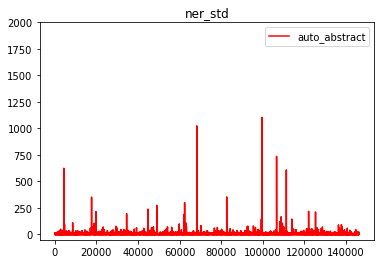

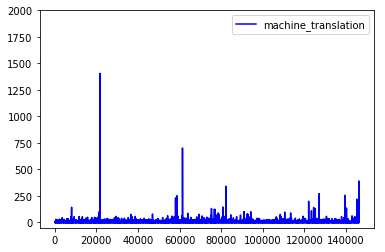

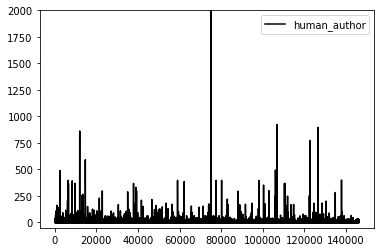

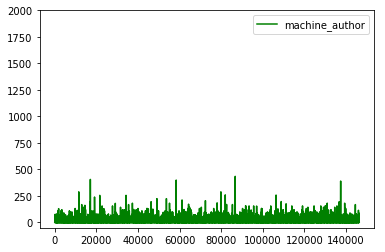

In [21]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15,10))
# plt.title("ner_std",fontdict={'size': 20, 'color': 'black'})
# plt.plot(train_data[train_data.label == '自动摘要']['pad_ner_std_sent'], color='red',label = 'auto_abstract')
# plt.plot(train_data[train_data.label == '机器翻译']['pad_ner_std_sent'], color='blue',label = 'machine_translation')
# plt.plot(train_data[train_data.label == '人类作者']['pad_ner_std_sent'], color='black',label = 'human_author')
# plt.plot(train_data[train_data.label == '机器作者']['pad_ner_std_sent'], color='green',label = 'machine_author')
# plt.legend(loc='upper right') 
# plt.show()

import matplotlib.pyplot as plt
# plt.figure(figsize=(15,10))
plt.title("ner_std")
plt.plot(train_data[train_data.label == '自动摘要']['pad_ner_std_sent'], color='red',label = 'auto_abstract')
plt.ylim(-50, 2000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器翻译']['pad_ner_std_sent'], color='blue',label = 'machine_translation')
plt.ylim(-50, 2000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '人类作者']['pad_ner_std_sent'], color='black',label = 'human_author')
plt.ylim(-50, 2000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器作者']['pad_ner_std_sent'], color='green',label = 'machine_author')
plt.ylim(-50, 2000)
plt.legend(loc='upper right') 
plt.show()

In [105]:
#每条数据的停用词分析
with open("dict/stop_word.dict", 'r',encoding='utf-8') as f:
    lines = f.readlines()
    stop_word = [line.strip() for line in lines]
    
stop_num_all = []
stop_num_mean = []
stop_num_std = []
for i in tqdm(range(len(train_data))):
    words_list = train_data.loc[i,'pad_words'].split("<sssss>")
    stop_num = []
    for words in words_list:
        stop_num.append(len(list(filter(lambda x: x in stop_word, words.split(" ")))))
    stop_num_mean.append(sum(stop_num)/len(stop_num))
    stop_num_std.append(np.var(np.array(stop_num)))
    stop_num_all.append(stop_num)
  
train_data['stop_num_sent'] = stop_num_all
train_data['stop_num_mean_sent'] = stop_num_mean
train_data['stop_num_std_sent'] = stop_num_std

100%|██████████| 78041/78041 [02:21<00:00, 552.30it/s]


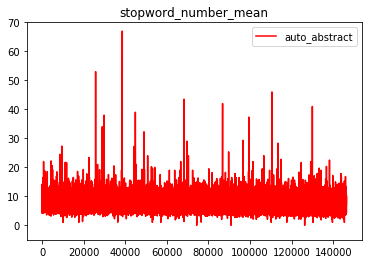

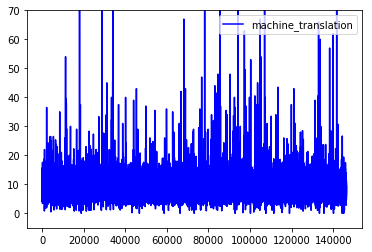

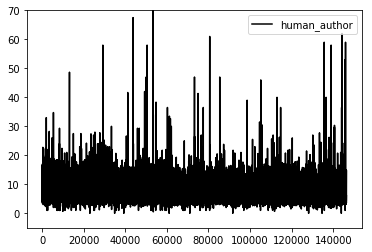

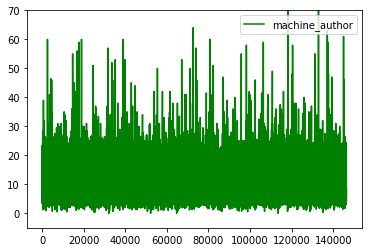

In [23]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(15,10))
plt.title("stopword_number_mean")
plt.plot(train_data[train_data.label == '自动摘要']['stop_num_mean_sent'], color='red',label = 'auto_abstract')
plt.ylim(-5, 70)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器翻译']['stop_num_mean_sent'], color='blue',label = 'machine_translation')
plt.ylim(-5, 70)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '人类作者']['stop_num_mean_sent'], color='black',label = 'human_author')
plt.ylim(-5, 70)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器作者']['stop_num_mean_sent'], color='green',label = 'machine_author')
plt.ylim(-5, 70)
plt.legend(loc='upper right') 
plt.show()

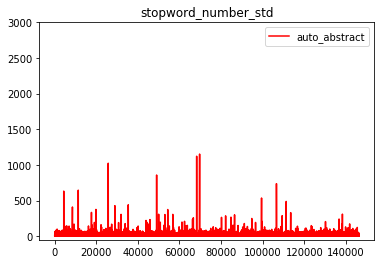

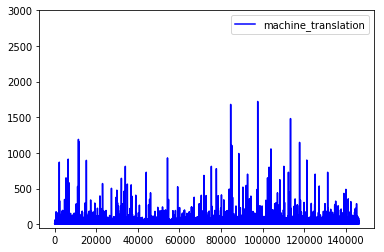

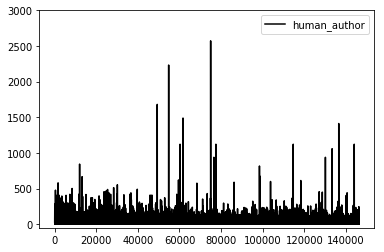

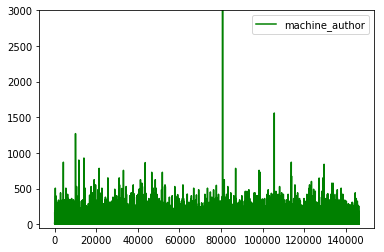

In [24]:
import matplotlib.pyplot as plt
plt.title("stopword_number_std")
plt.plot(train_data[train_data.label == '自动摘要']['stop_num_std_sent'], color='red',label = 'auto_abstract')
plt.ylim(-50, 3000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器翻译']['stop_num_std_sent'], color='blue',label = 'machine_translation')
plt.ylim(-50, 3000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '人类作者']['stop_num_std_sent'], color='black',label = 'human_author')
plt.ylim(-50, 3000)
plt.legend(loc='upper right') 
plt.show()

plt.plot(train_data[train_data.label == '机器作者']['stop_num_std_sent'], color='green',label = 'machine_author')
plt.ylim(-50, 3000)
plt.legend(loc='upper right') 
plt.show()



In [109]:
train_data.loc[:, 'min_sent_len'] = min_sent_length(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'min_sent_word_len'] = min_sent_word_len(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'last_char'] = get_last_char(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'first_char'] = get_first_char(train_data.loc[:, 'pad_content'])
train_data.loc[:, 'first_word'] = get_first_word(train_data.loc[:, 'pad_words'])
train_data.loc[:, 'last_word'] = get_last_word(train_data.loc[:, 'pad_words'])
tags = ['eng', 'num', 'date', 'time']
for tag in tags:
    train_data.loc[:, 'first_%s' % tag] = first_tag_position(train_data.loc[:, 'pad_words'], '<%s>' % tag)

ValueError: min() arg is an empty sequence

In [116]:
# train_data = train_data.drop('content', axis=1)
# train_data = train_data.drop('pad_content', axis=1)
# train_data = train_data.drop('pad_words', axis=1)
# train_data = train_data.drop('sent_label', axis=1)
# train_data = train_data.drop('pad_pos', axis=1)
# train_data = train_data.drop('pad_ner', axis=1)
# train_data = train_data.drop('pad_ner_sent', axis=1)
# train_data = train_data.drop('pad_ner_counts_sent', axis=1)
# train_data = train_data.drop('stop_num_sent', axis=1)
pd.set_option('max_colwidth',200)
pd.set_option('max_rows',200)
pd.set_option('max_columns',None)
train_data

,id,double_comma,text_len,eng_count,num_count,datetime_count,special_count,count_comma,para_num,sent_num,text_word_len,first_para_len,first_para_word_len,max_para_len,min_para_len,max_para_word_len,min_para_word_len,first_sent_len,max_sent_len,max_sent_word_len,pad_ner_mean_sent,pad_ner_std_sent,stop_num_mean_sent,stop_num_std_sent
0,204988,4,403,0,5,5,0,1,18,39,253,23,14,68,1,36,3,2,28,16,2.789474,1.955679,4.842105,10.869806
1,204989,0,352,6,47,3,0,0,2,4,190,257,91,257,93,91,37,256,256,90,3.333333,0.222222,12.666667,9.555556
2,204990,0,384,0,10,5,0,0,11,28,238,30,19,54,18,32,11,4,34,16,2.083333,0.409722,7.500000,12.250000
3,204991,0,375,3,4,3,0,0,5,22,205,105,49,119,21,58,14,26,41,19,4.666667,7.888889,11.833333,22.472222
4,204992,2,390,0,4,4,0,0,13,32,226,59,23,59,1,31,3,26,35,17,2.857143,0.979592,4.000000,4.000000
5,204993,0,456,2,32,6,0,2,6,29,200,58,24,93,32,43,18,13,100,44,3.000000,4.285714,6.285714,1.632653
6,204994,0,426,2,1,0,0,0,8,33,235,60,35,101,23,60,10,13,36,17,2.888889,2.765432,8.777778,44.839506
7,204995,0,443,0,13,4,0,0,20,42,266,21,12,59,7,27,6,11,42,17,2.952381,1.473923,4.047619,4.712018
8,204996,0,235,0,1,1,0,0,7,15,135,10,6,78,10,44,6,9,35,22,2.375000,0.734375,5.875000,20.109375
9,204997,2,403,3,12,10,0,0,8,25,198,90,39,90,1,39,3,6,35,16,2.222222,0.172840,6.444444,12.469136


In [117]:
# train_data.to_csv('/data/lengjia/smp/train_double_comma.json',columns=['id','label', 'double_comma'])
# train_data.to_csv('/data/lengjia/smp/test_data.csv',
#                   columns=['id', 'content','text_len', 'eng_count', 'num_count', 'datetime_count',
#                            'special_count','count_comma', 'para_num', 'sent_num', 'text_word_len', 'first_para_len', 
#                            'first_para_word_len', 'max_para_len', 'min_para_len', 'max_para_word_len', 'min_para_word_len', 
#                            'first_sent_len', 'max_sent_len', 'max_sent_word_len', 'pad_ner_mean_sent', 'pad_ner_std_sent',
#                            'stop_num_mean_sent', 'stop_num_std_sent','double_comma'])
train_data.to_json('/data/lengjia/smp/test_data.json',orient='split')

In [119]:
pd.read_json('/data/lengjia/smp/test_data.json', orient='split')

,id,double_comma,text_len,eng_count,num_count,datetime_count,special_count,count_comma,para_num,sent_num,text_word_len,first_para_len,first_para_word_len,max_para_len,min_para_len,max_para_word_len,min_para_word_len,first_sent_len,max_sent_len,max_sent_word_len,pad_ner_mean_sent,pad_ner_std_sent,stop_num_mean_sent,stop_num_std_sent
0,204988,4,403,0,5,5,0,1,18,39,253,23,14,68,1,36,3,2,28,16,2.789474,1.955679,4.842105,10.869806
1,204989,0,352,6,47,3,0,0,2,4,190,257,91,257,93,91,37,256,256,90,3.333333,0.222222,12.666667,9.555556
2,204990,0,384,0,10,5,0,0,11,28,238,30,19,54,18,32,11,4,34,16,2.083333,0.409722,7.500000,12.250000
3,204991,0,375,3,4,3,0,0,5,22,205,105,49,119,21,58,14,26,41,19,4.666667,7.888889,11.833333,22.472222
4,204992,2,390,0,4,4,0,0,13,32,226,59,23,59,1,31,3,26,35,17,2.857143,0.979592,4.000000,4.000000
5,204993,0,456,2,32,6,0,2,6,29,200,58,24,93,32,43,18,13,100,44,3.000000,4.285714,6.285714,1.632653
6,204994,0,426,2,1,0,0,0,8,33,235,60,35,101,23,60,10,13,36,17,2.888889,2.765432,8.777778,44.839506
7,204995,0,443,0,13,4,0,0,20,42,266,21,12,59,7,27,6,11,42,17,2.952381,1.473923,4.047619,4.712018
8,204996,0,235,0,1,1,0,0,7,15,135,10,6,78,10,44,6,9,35,22,2.375000,0.734375,5.875000,20.109375
9,204997,2,403,3,12,10,0,0,8,25,198,90,39,90,1,39,3,6,35,16,2.222222,0.172840,6.444444,12.469136


In [84]:
data = train_data[train_data['double_comma'] != 0]
error = data[data["label"] == '自动摘要']

# train

In [76]:
# train_data2 = train_data[(train_data.label=='人类作者') &(train_data.label=='自动摘要') ]
df1 = train_data[train_data["label"]== '人类作者']
df2 = train_data[train_data["label"]== '自动摘要']
train_data2 = pd.concat([df1,df2] ,axis=0)

In [120]:
train_data

,id,double_comma,text_len,eng_count,num_count,datetime_count,special_count,count_comma,para_num,sent_num,text_word_len,first_para_len,first_para_word_len,max_para_len,min_para_len,max_para_word_len,min_para_word_len,first_sent_len,max_sent_len,max_sent_word_len,pad_ner_mean_sent,pad_ner_std_sent,stop_num_mean_sent,stop_num_std_sent
0,204988,4,403,0,5,5,0,1,18,39,253,23,14,68,1,36,3,2,28,16,2.789474,1.955679,4.842105,10.869806
1,204989,0,352,6,47,3,0,0,2,4,190,257,91,257,93,91,37,256,256,90,3.333333,0.222222,12.666667,9.555556
2,204990,0,384,0,10,5,0,0,11,28,238,30,19,54,18,32,11,4,34,16,2.083333,0.409722,7.500000,12.250000
3,204991,0,375,3,4,3,0,0,5,22,205,105,49,119,21,58,14,26,41,19,4.666667,7.888889,11.833333,22.472222
4,204992,2,390,0,4,4,0,0,13,32,226,59,23,59,1,31,3,26,35,17,2.857143,0.979592,4.000000,4.000000
5,204993,0,456,2,32,6,0,2,6,29,200,58,24,93,32,43,18,13,100,44,3.000000,4.285714,6.285714,1.632653
6,204994,0,426,2,1,0,0,0,8,33,235,60,35,101,23,60,10,13,36,17,2.888889,2.765432,8.777778,44.839506
7,204995,0,443,0,13,4,0,0,20,42,266,21,12,59,7,27,6,11,42,17,2.952381,1.473923,4.047619,4.712018
8,204996,0,235,0,1,1,0,0,7,15,135,10,6,78,10,44,6,9,35,22,2.375000,0.734375,5.875000,20.109375
9,204997,2,403,3,12,10,0,0,8,25,198,90,39,90,1,39,3,6,35,16,2.222222,0.172840,6.444444,12.469136


In [26]:
features = [
    'text_len', 'eng_count', 'num_count','datetime_count','special_count','count_comma', 'para_num', 'sent_num'
      'first_char', 'first_date',
       'first_eng', 'first_idiom', 'first_name', 'first_namef', 'first_num',
       'first_org', 'first_para_len', 'first_para_word_len', 'first_placef',
       'first_sent_len', 'first_time', 'id', 'idiom_count', 
       'last_char', 'max_para_len', 'max_para_word_len', 'max_sent_len',
# #        'max_sent_word_len', 'min_para_len', 'min_para_word_len',
#        'min_sent_len', 'min_sent_word_len', 'name_count', 'namef_count',
#         'org_count', 'place_count',
#        'placef_count',  , 'text_word_len',
            "pad_ner_std_sent",
            "pad_ner_mean_sent",
            "stop_num_mean_sent",
            "stop_num_std_sent",
#             "mean_len_clause",
#             "var_len_clause"
]


In [77]:
features = ['double_comma']

In [79]:
X = train_data2.loc[:, features]
label = train_data2['label']
X = np.array(X)
labels = {'人类作者':1,  '自动摘要': 0}
# labels = {'人类作者': 0, '机器作者': 1, '机器翻译': 2, '自动摘要': 3}
y = np.array([labels[l] for l in label])


In [80]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

/home/lengjia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [81]:
from sklearn.metrics import classification_report
from sklearn import metrics 
import lightgbm as lgb
dtrain_data1 = lgb.Dataset(X_train, y_train)
dtest_data1 = lgb.Dataset(X_test)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 4,
    'learning_rate': 0.1,
    'num_leaves': 100,  
    'max_depth': -2,  
    'min_data_in_leaf': 300,  
    'learning_rate': 0.1,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.95,  
    'bagging_freq': 2,  
    'lambda_l1': 1,    
    'lambda_l2': 0.001,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.2,  
    'verbose': 5,  
    'is_unbalance': True 
}
print('Start training...')
bst1 = lgb.train(params, dtrain_data1, num_boost_round=100)

predict1 = bst1.predict(X_test)
predict1 = [np.argmax(p) for p in predict1]
print(
    classification_report(
        y_test,
        predict1,
        target_names=['人类作者', '自动摘要'],digits = 2
        ))
print (metrics.f1_score(y_test,predict1,average="macro"))


Start training...
             precision    recall  f1-score   support

       人类作者       0.83      1.00      0.91      6286
       自动摘要       1.00      0.86      0.93      9516

avg / total       0.93      0.92      0.92     15802

0.9166119948166158
